In [1]:
%load_ext autoreload
%autoreload 2
import os; import sys; sys.path.insert(0,'../')
import pandas as pd
import numpy as np
import tqdm
import warnings
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

import socceraction.atomic.features as fs
#import socceraction.atomic.labels as lab

In [2]:
## Configure file and folder names
datafolder = "../data/private"
spadl_h5 = os.path.join(datafolder,"spadl-statsbomb.h5")

In [3]:
games = pd.read_hdf(spadl_h5,"games")
games = games[(games.competition_name == "Premier League")
             & (games.season_name == "2018/2019")]
print("nb of games:", len(games))

actiontypes = pd.read_hdf(spadl_h5, "atomic_actiontypes")
bodyparts = pd.read_hdf(spadl_h5, "bodyparts")

nb of games: 380


In [4]:
with pd.HDFStore(spadl_h5) as spadlstore:
    actions = []
    for game in tqdm.tqdm(games.itertuples()):
        a = spadlstore[f"atomic_actions/game_{game.game_id}"]
        [a] = fs.play_left_to_right([a],game.home_team_id)
        actions.append(a)
    actions = pd.concat(actions)
    actions = actions.merge(spadlstore["atomic_actiontypes"],how="left")
actions[:5]

380it [00:08, 42.60it/s]


game_id  period_id  action_id  time_seconds     timestamp  team_id  \
0  14562.0        1.0          0           1.0  00:00:01.344     58.0   
1  14562.0        1.0          1           1.5  00:00:02.117     58.0   
2  14562.0        1.0          2           2.0  00:00:02.117     58.0   
3  14562.0        1.0          3           2.0  00:00:02.969     58.0   
4  14562.0        1.0          4           3.0  00:00:04.338     58.0   

   player_id          x          y         dx         dy  type_id  \
0     9923.0  52.058824  34.430380 -10.588235  -0.000000        0   
1     9917.0  41.470588  34.430380  -0.000000  -0.000000       23   
2     9917.0  41.470588  34.430380  -0.000000  -0.000000       21   
3     9917.0  41.470588  34.430380 -15.882353 -14.632911        0   
4     9924.0  25.588235  19.797468  -0.000000  -0.000000       23   

   bodypart_id type_name  
0            0      pass  
1            0  receival  
2            0   dribble  
3            0      pass  
4            0  receival

In [12]:
from scipy.spatial import Delaunay
import networkx as nx

def color_clusters(clusters,colors):
    tri = Delaunay(clusters)
    edges = set()
    for s in tri.simplices:
        [a,b,c] = s
        es = set([frozenset([a,b]),frozenset([b,c]),frozenset([c,a])])
        edges = edges | es
    G = nx.Graph()
    for e in edges:
        [i,j] = list(e)
        G.add_edge(i, j)
    
    if len(G.nodes) > 0:
        r_ = max([G.degree(node) for node in G.nodes])
    else:
        r_ = 0
    if r_ > len(colors)-1:
        colorassign = nx.algorithms.coloring.greedy_color(G)
    else:
        colorassign = nx.algorithms.coloring.equitable_color(G,len(colors))
    colorvector = [0] * len(clusters)
    for k,v in colorassign.items():
        colorvector[k] = int(v)
    return [colors[i] for i in colorvector]

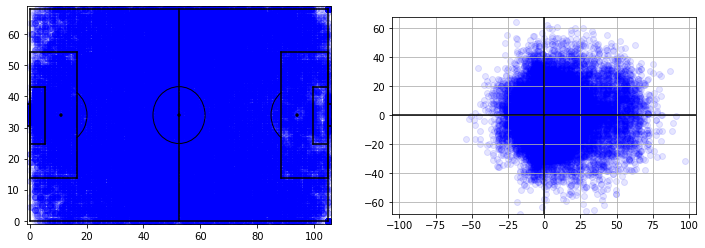

In [217]:
import matplotsoccer as mps
import matplotlib.pyplot as plt

#a = actions[actions.type_name == "shot"][:100]


def plot_deltas(x,y,dx,dy,color):
    fig,axs = plt.subplots(1,2)
    fig.set_size_inches((12,4))
    axs[0].scatter(x,y,color=color,alpha=0.1)
    axs[1].scatter(dx,dy,color=color,alpha=0.1)
    mps.field(ax=axs[0],show=False)
    plt.axis("on")
    plt.axis("scaled")
    axs[1].axvline(0,color="black")
    axs[1].axhline(0,color="black")
    axs[1].grid()
    axs[0].set_xlim(-1,105+1)
    axs[0].set_ylim(-1,68+1)
    #axs[1].set_xlim(-1.1,1.1)
    #axs[1].set_ylim(-1.1,1.1)
    axs[1].set_xlim(-105,105)
    axs[1].set_ylim(-68,68)
    plt.show()
plot_deltas(a.x,a.y,a.dx,a.dy,color="blue")

In [205]:
set(actions.type_name)
atoh = fs.feature_column_names([fs.actiontype_onehot],1)

100000


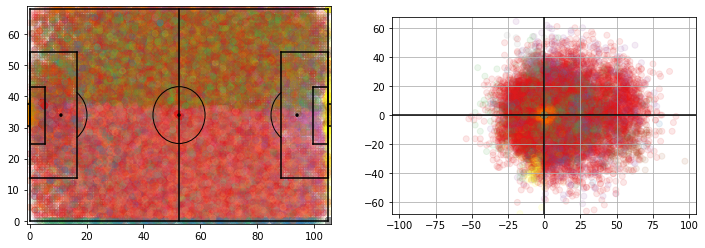

['x', 'y', 'type_bad_touch_a0']


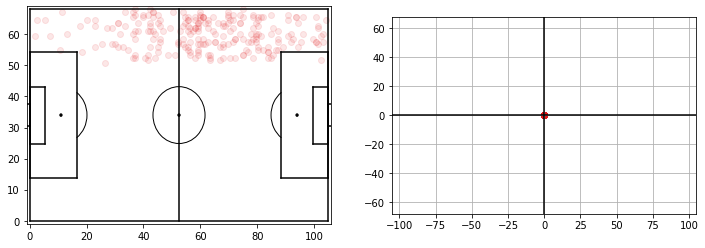

['x', 'y', 'dx', 'type_clearance_a0']


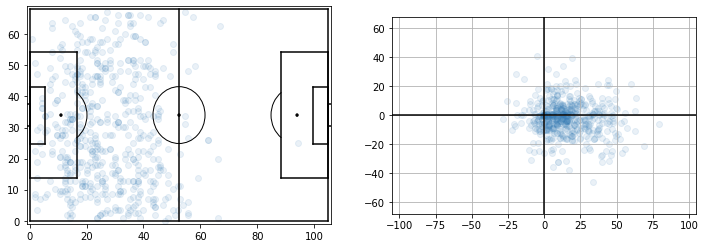

['x', 'type_out_a0']


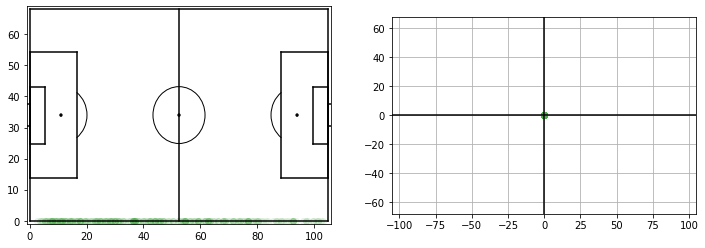

['x', 'y', 'type_interception_a0']


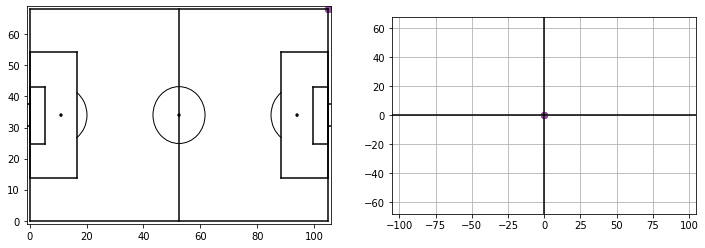

['x', 'y', 'type_tackle_a0']


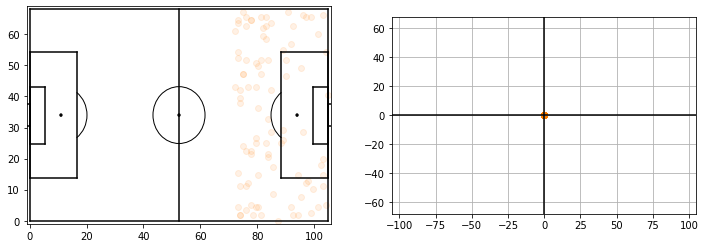

['x', 'y', 'type_red_card_a0']


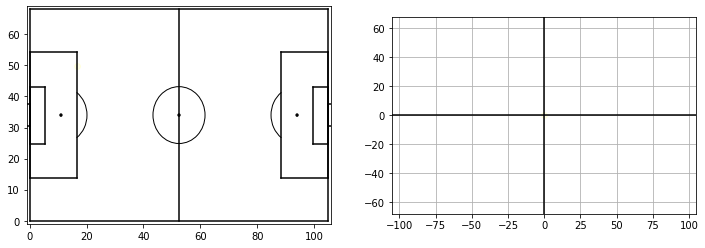

['x', 'y', 'type_take_on_a0']


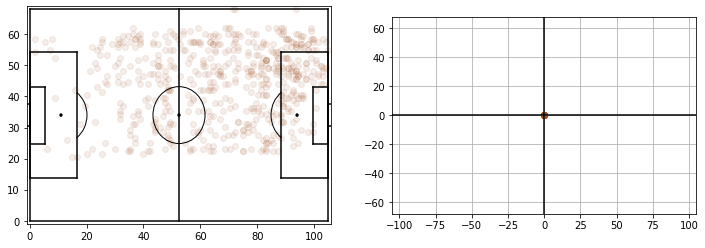

['x', 'y', 'type_out_a0']


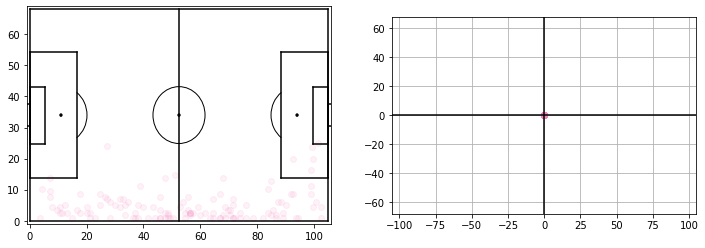

['x', 'y', 'type_bad_touch_a0']


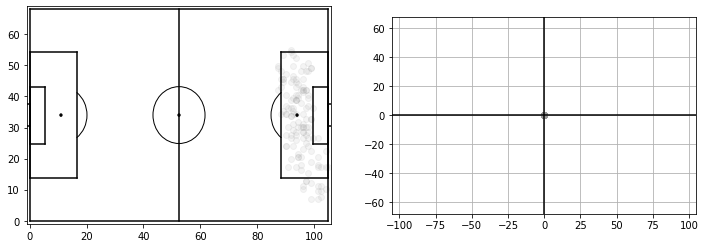

['x', 'y', 'type_interception_a0']


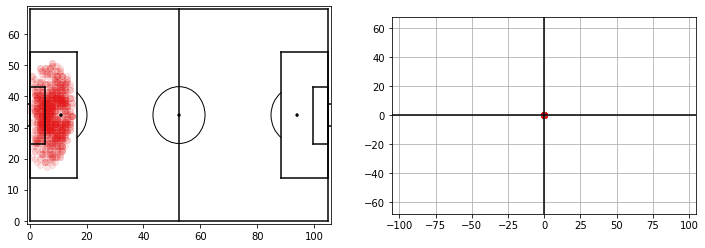

['x', 'y', 'type_clearance_a0']


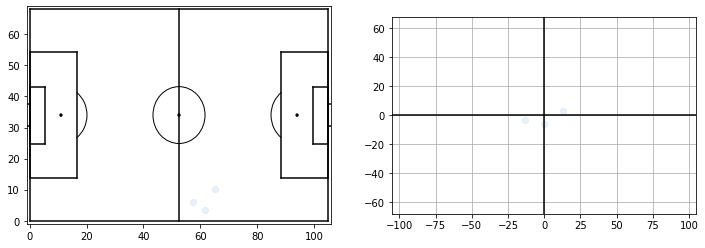

['x', 'y', 'type_foul_a0']


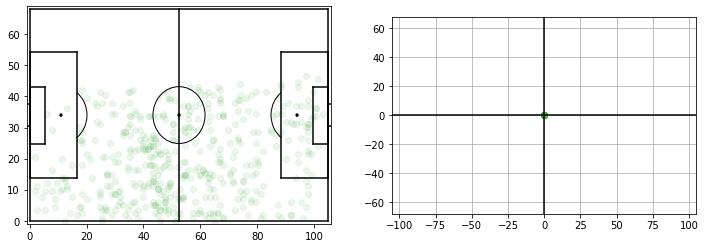

['x', 'y', 'dx', 'type_freekick_crossed_a0']


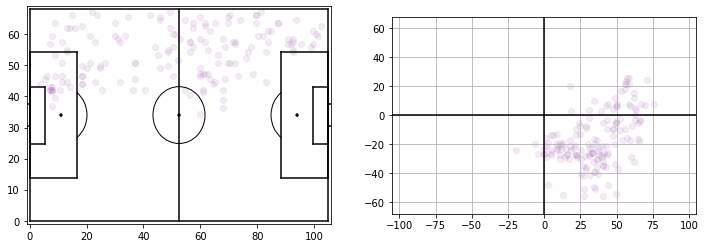

['x', 'y', 'type_keeper_save_a0', 'type_keeper_claim_a0', 'type_keeper_punch_a0', 'type_owngoal_a0']


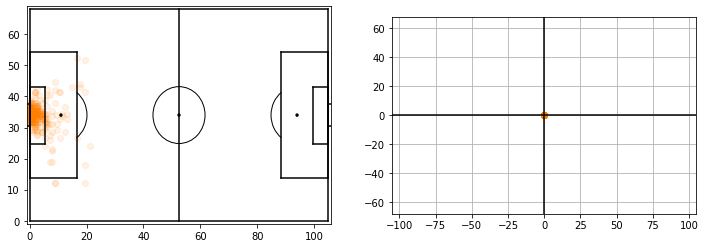

['x', 'y', 'type_out_a0', 'type_yellow_card_a0']


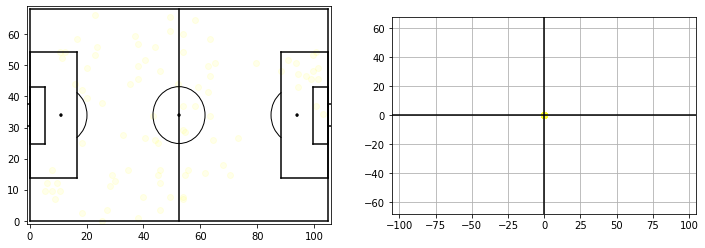

['x', 'y', 'dx', 'type_goalkick_a0']


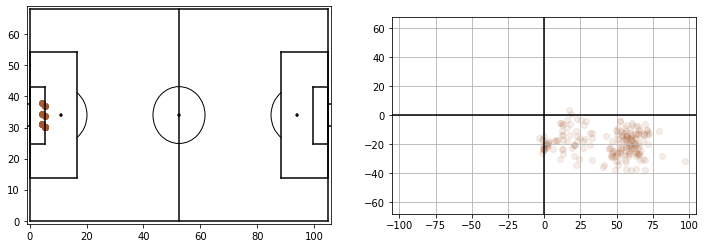

['x', 'y', 'type_bad_touch_a0']


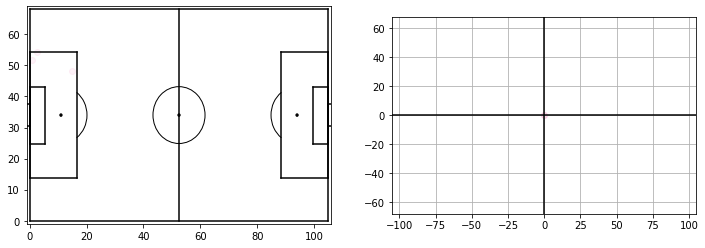

['x', 'type_interception_a0']


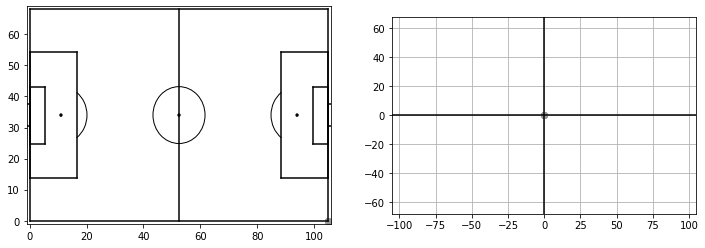

['x', 'y', 'dx', 'dy', 'type_pass_a0']


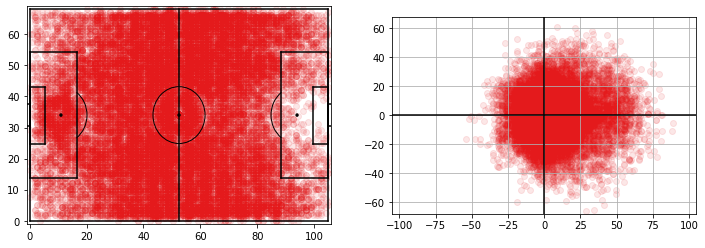

['x', 'dx', 'dy', 'type_throw_in_a0']


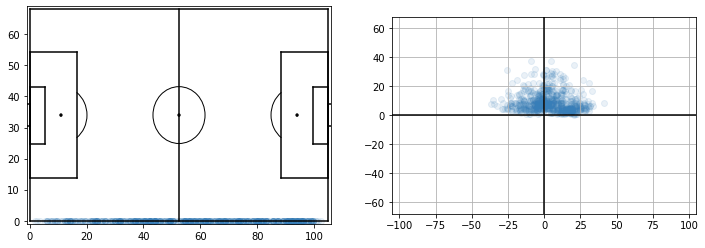

['x', 'y', 'dy', 'type_freekick_short_a0']


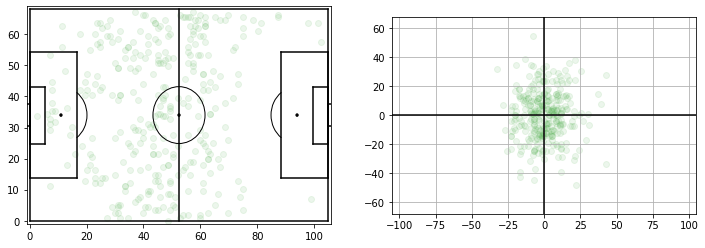

['x', 'y', 'dx', 'dy', 'type_cross_a0', 'type_shot_a0']


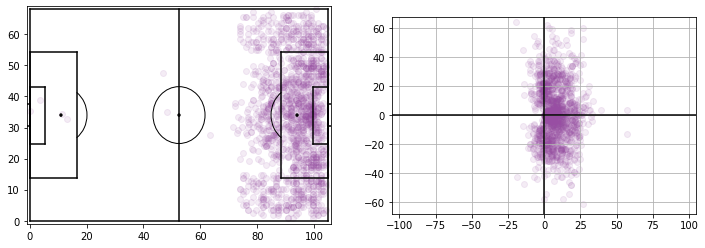

['x', 'y', 'type_throw_in_a0']


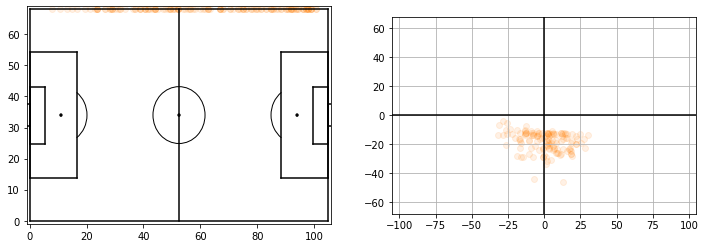

['x', 'y', 'type_out_a0']


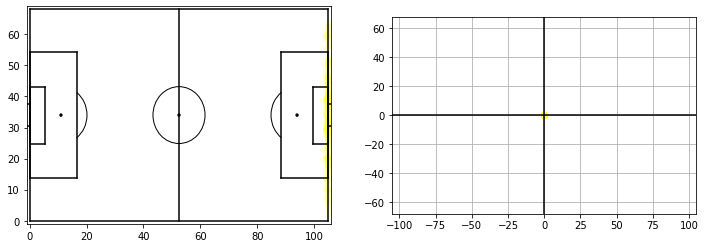

['x', 'y', 'dy', 'type_freekick_short_a0']


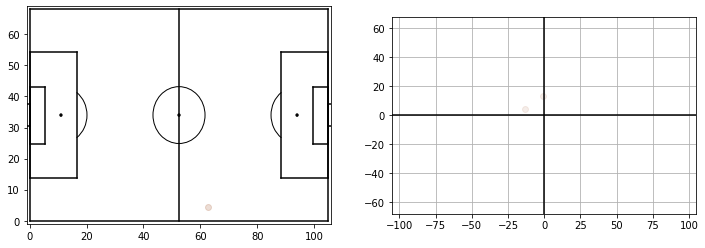

['x', 'y', 'type_receival_a0']


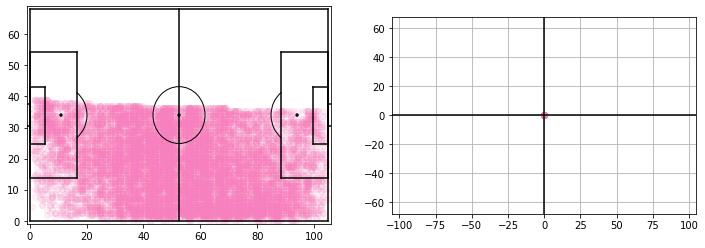

['x', 'y', 'type_interception_a0']


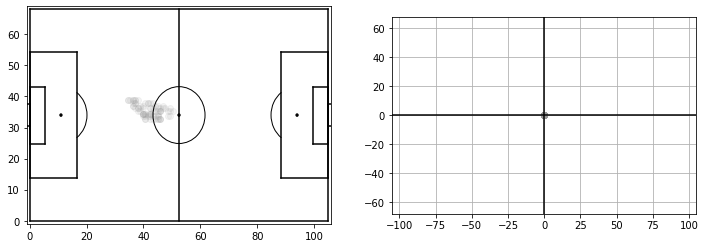

['x', 'y', 'dx', 'type_shot_freekick_a0']


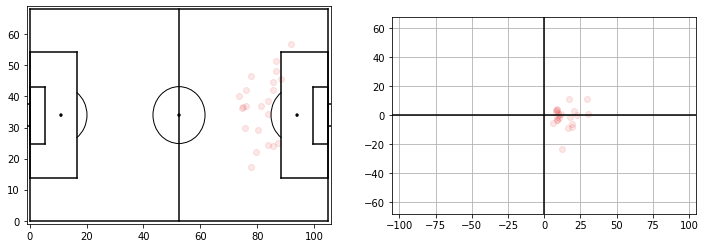

['x', 'y', 'dx', 'type_clearance_a0']


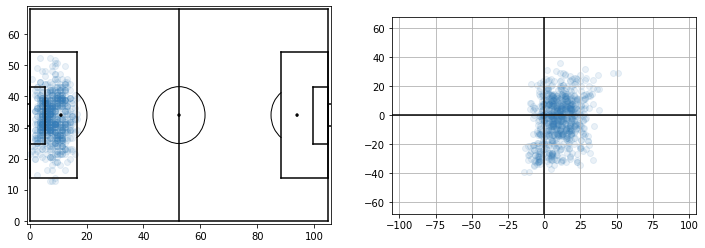

['x', 'y', 'dx', 'dy', 'type_clearance_a0']


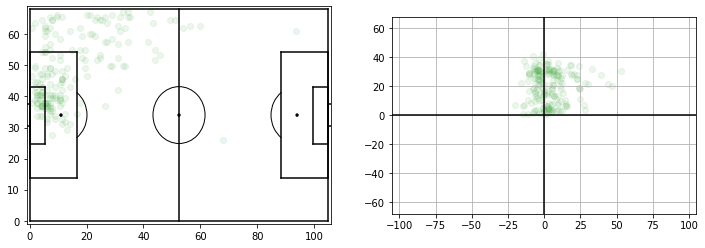

['x', 'y', 'dx', 'dy', 'type_freekick_crossed_a0']


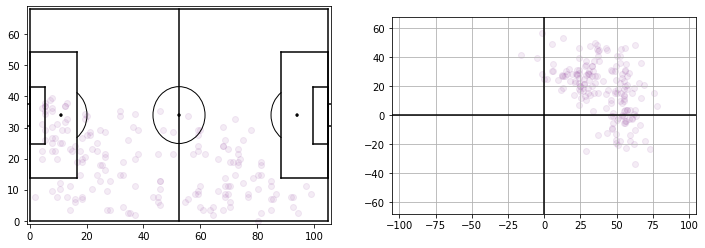

['x', 'y', 'dx', 'type_dribble_a0']


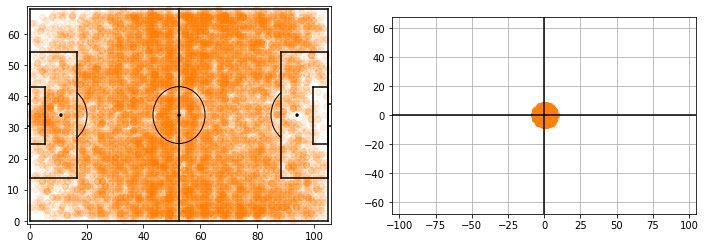

['x', 'y', 'type_corner_crossed_a0', 'type_corner_short_a0']


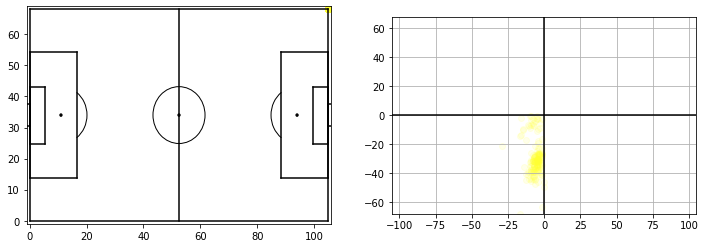

['x', 'y', 'dx', 'dy', 'type_shot_penalty_a0', 'type_offside_a0', 'type_goal_a0']


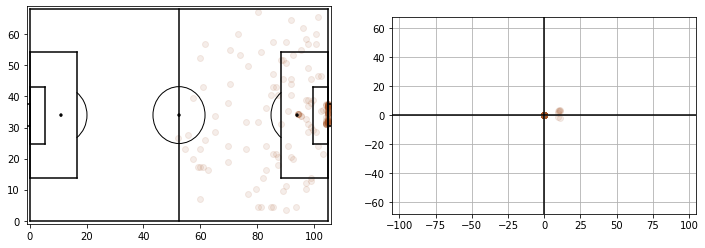

['x', 'y', 'type_bad_touch_a0']


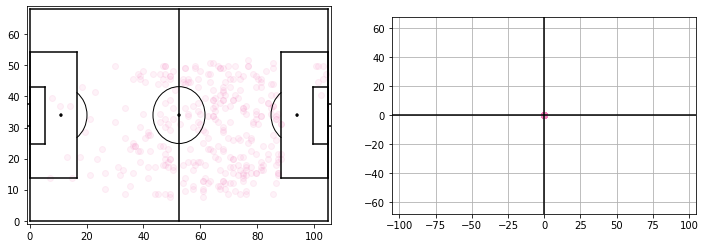

['x', 'y', 'type_take_on_a0']


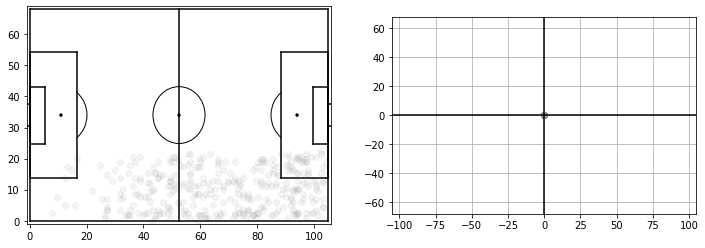

['x', 'y', 'dx', 'dy', 'type_goalkick_a0']


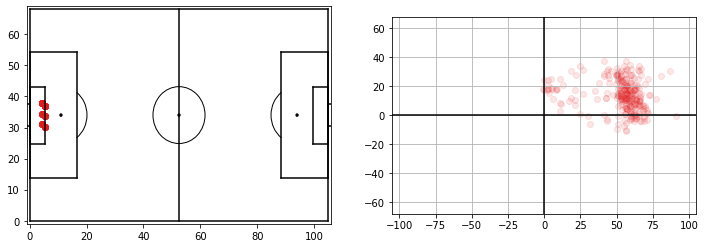

['x', 'y', 'type_interception_a0']


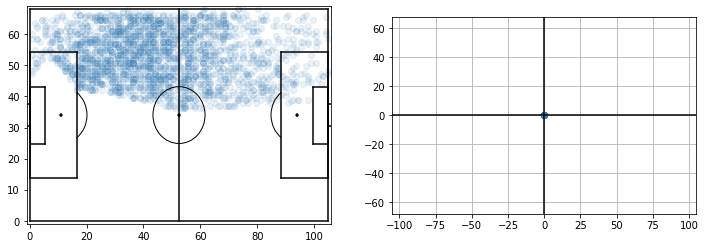

['x', 'y', 'type_receival_a0']


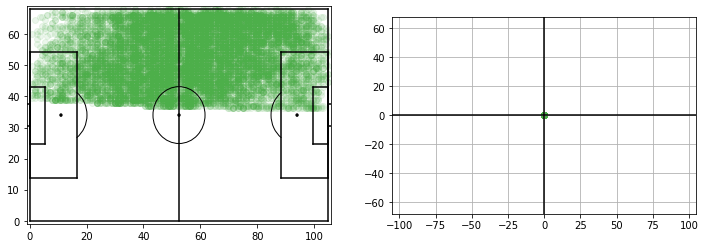

['x', 'y', 'type_interception_a0']


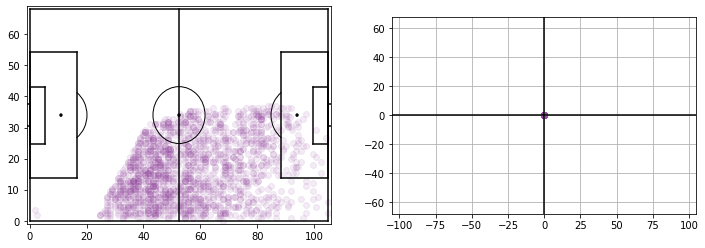

['x', 'y', 'type_out_a0']


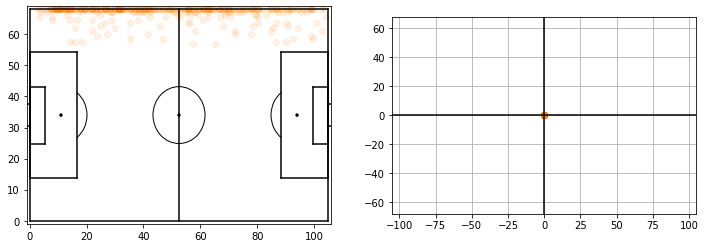

['x', 'y', 'type_foul_a0']


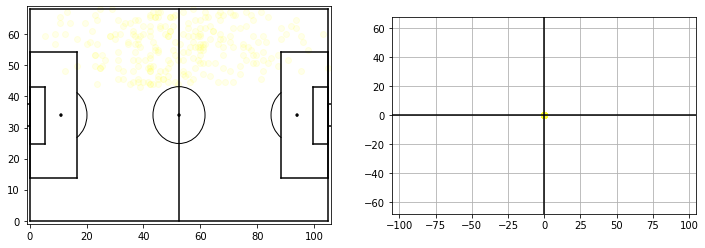

['x', 'y', 'dx', 'type_dribble_a0']


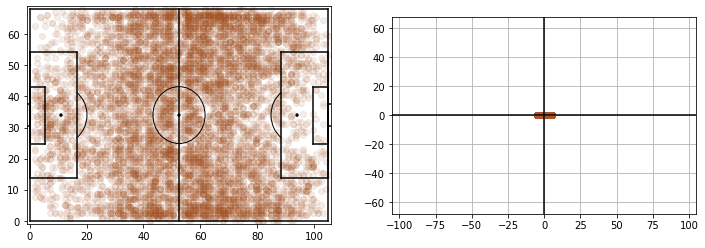

['x', 'y', 'type_take_on_a0']


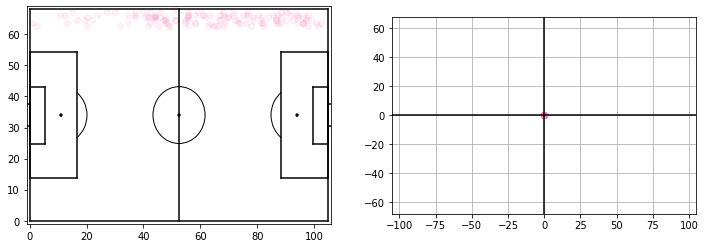

['x', 'dy', 'type_corner_crossed_a0', 'type_corner_short_a0']


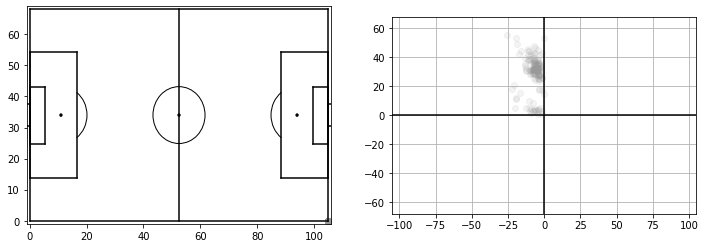

['x', 'y', 'type_tackle_a0']


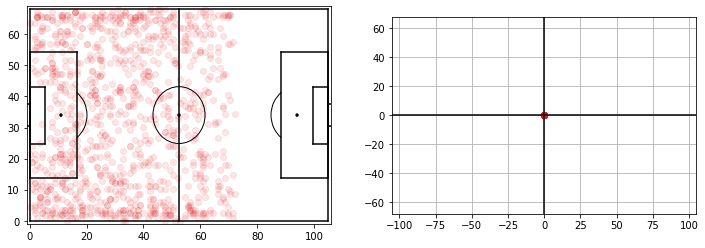

['x', 'y', 'type_interception_a0']


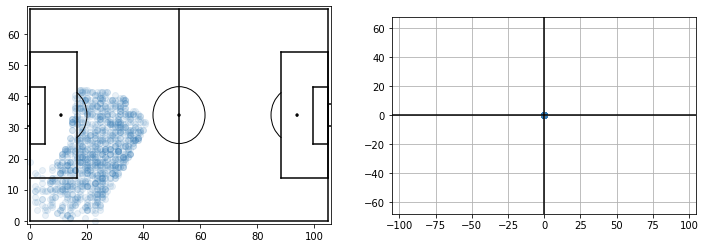

['x', 'y', 'dx', 'dy', 'type_dribble_a0']


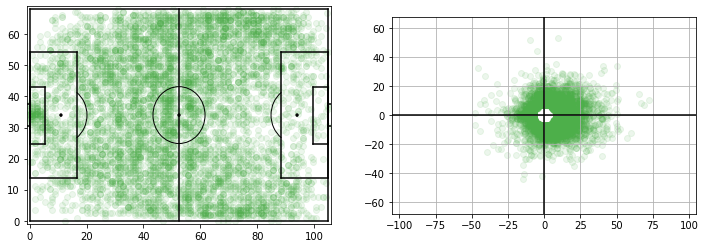

['x', 'y', 'dx', 'type_throw_in_a0']


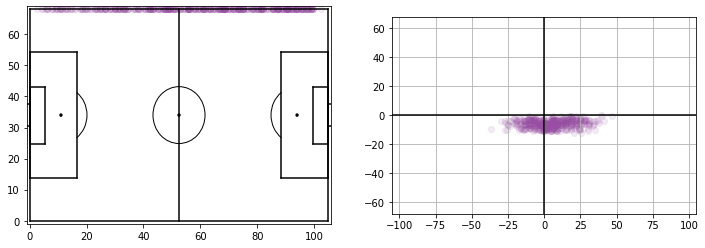

['x', 'y', 'type_bad_touch_a0']


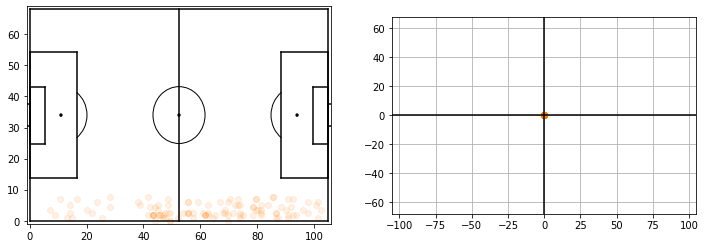

CPU times: user 48.6 s, sys: 6.66 s, total: 55.2 s
Wall time: 39.7 s


In [219]:
%%time
import sklearn.cluster as clus
import sklearn.mixture as mix
import socceraction.atomic.features as fs

a = actions[:100000].copy()

#a = actions[actions.type_name == "throw_in"][:40000].copy()
a = a.fillna(0)
#a = actions[:100000].copy()
print(len(a))
di = fs.direction(a)
#a["dx"] = di.dx_a0
#a["dy"] = di.dy_a0
a[atoh]= fs.actiontype_onehot(a).applymap(int)
nbc = 50

cols = ["x","y", "dx","dy"] + atoh

# gmm = mix.GaussianMixture(nbc,verbose=2).fit(a[["x","y",
#                                       "dx","dy",
#                                      ]])
#gmm = mix.GaussianMixture(nbc,verbose=2).fit(a[cols])

colors = ["#e41a1c",
"#377eb8",
"#4daf4a",
"#984ea3",
"#ff7f00",
"#ffff33",
"#a65628",
"#f781bf",
"#999999",
         ]
clustercolors = colors * 10
#color_clusters([(x,y) for (x,y,dx,dy) in gmm.means_],colors)
#print(clustercolors)
#labels = gmm.predict(a[cols])
#                      [["x","y",
#                         "dx","dy",
#                        ]])

plot_deltas(a.x,a.y,a.dx,a.dy,color=[clustercolors[l] for l in labels])
for l in set(labels):
    l_idx = labels == l
    m = [cols[i] for i, v in enumerate(gmm.means_[l]) if v > 0.01]
    print(list(m))
    plot_deltas(a.x[l_idx],a.y[l_idx],a.dx[l_idx],a.dy[l_idx],color=clustercolors[l])

In [148]:
sum(a.dx.isnull())

47

In [25]:
states = gmm.predict_proba(actions[["x","y"]])
states.shape

IndexError: boolean index did not match indexed array along dimension 0; dimension is 1188669 but corresponding boolean dimension is 1188670

In [184]:
actions = actions.fillna(0)
nex_actions = actions.shift(-1)
valid_idx = (actions.team_id == nex_actions.team_id) & (actions.period_id == nex_actions.period_id)
print(sum(valid_idx)/ len(valid_idx))
prev = gmm.predict_proba(actions[valid_idx][["x","y","dx","dy"]])
nex = gmm.predict_proba(nex_actions[valid_idx][["x","y","dx","dy"]])
prev,nex

0.8807810409953982


(array([[0.   , 0.   , 0.   , ..., 0.   , 0.004, 0.   ],
        [0.   , 0.   , 0.   , ..., 0.128, 0.054, 0.   ],
        [0.   , 0.   , 0.   , ..., 0.128, 0.054, 0.   ],
        ...,
        [0.   , 0.   , 0.   , ..., 0.004, 0.   , 0.157],
        [0.   , 0.   , 0.   , ..., 0.004, 0.   , 0.157],
        [0.   , 0.   , 0.   , ..., 0.   , 0.006, 0.   ]]),
 array([[0.   , 0.   , 0.   , ..., 0.128, 0.054, 0.   ],
        [0.   , 0.   , 0.   , ..., 0.128, 0.054, 0.   ],
        [0.   , 0.   , 0.   , ..., 0.   , 0.001, 0.   ],
        ...,
        [0.   , 0.   , 0.   , ..., 0.004, 0.   , 0.157],
        [0.   , 0.   , 0.   , ..., 0.   , 0.   , 0.   ],
        [0.   , 0.   , 0.   , ..., 0.   , 0.   , 0.   ]]))

(50, 1046958)


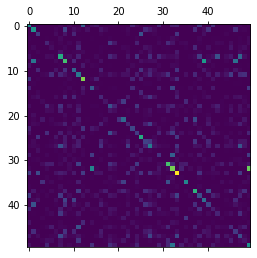

(0.9999999999999999, 1046958.0000000005)

In [222]:
np.set_printoptions(precision=3)
np.set_printoptions(suppress=True)
print(prev.T.shape)
trans = np.dot(prev.T,nex)
trans /= trans.sum()
#for i in range(len(trans)):
    #p(trans[:,i].sum())
plt.matshow(trans)
plt.show()
#trans = np.dot(trans.T,trans)
trans.sum(),prev.sum()

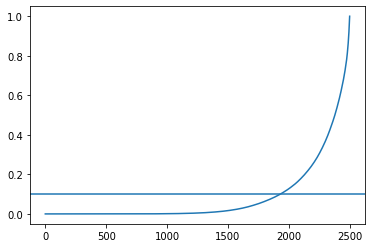

In [226]:
plt.plot(np.cumsum(sorted(trans.flatten())))
plt.axhline(0.1)
plt.show()

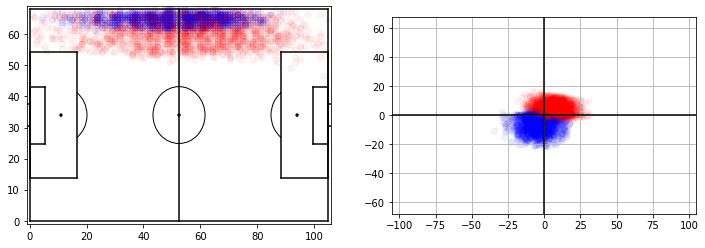

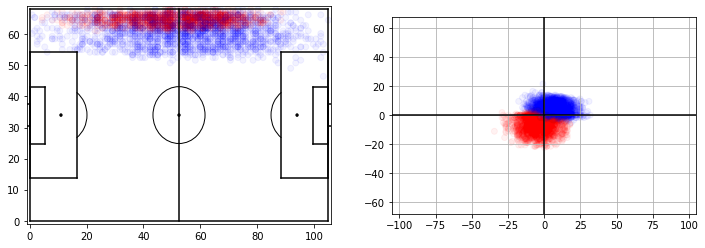

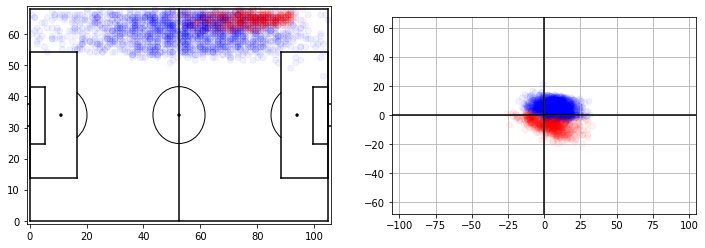

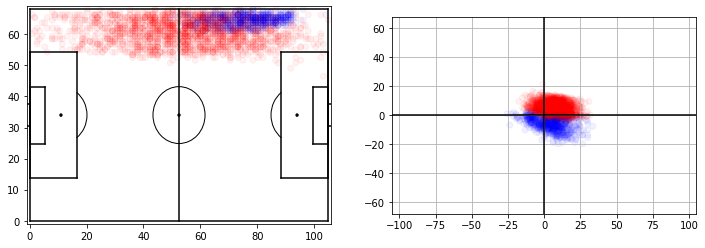

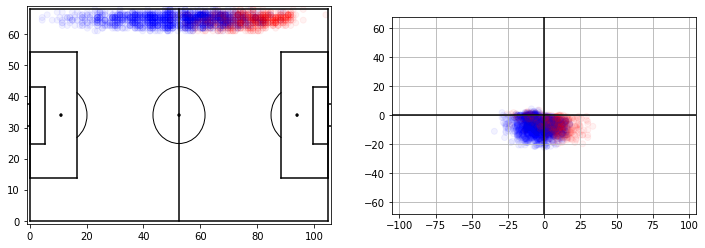

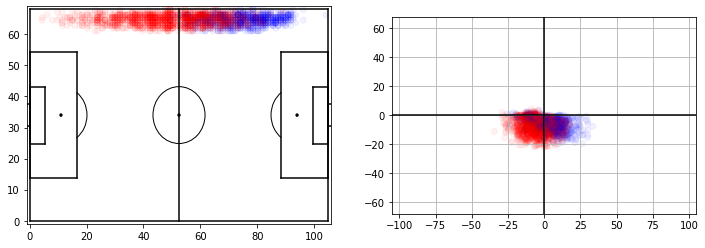

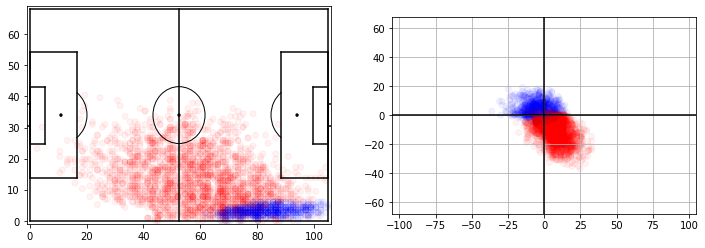

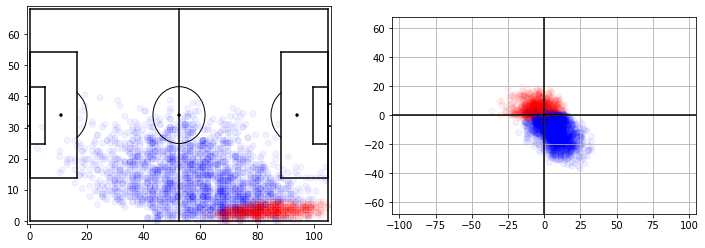

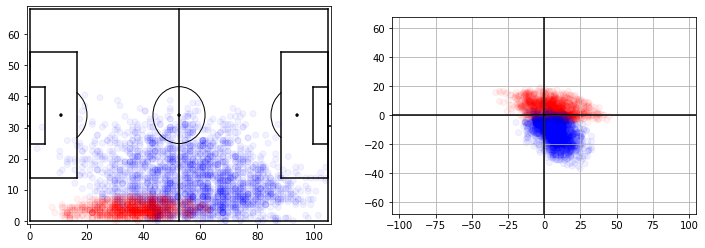

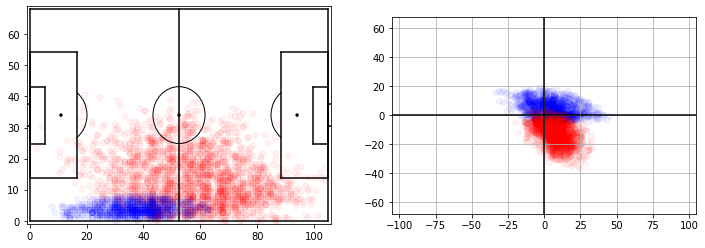

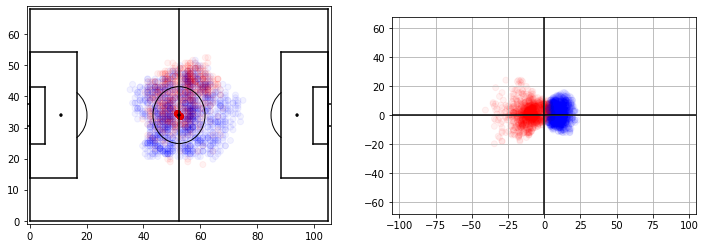

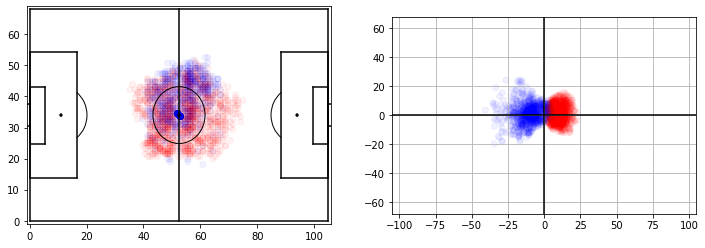

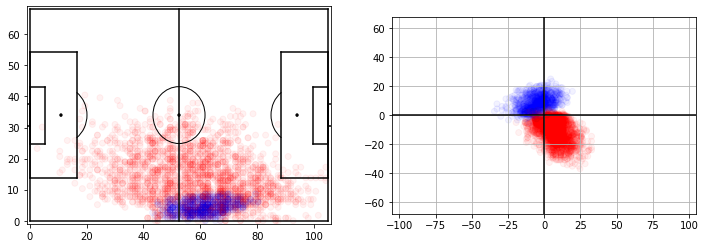

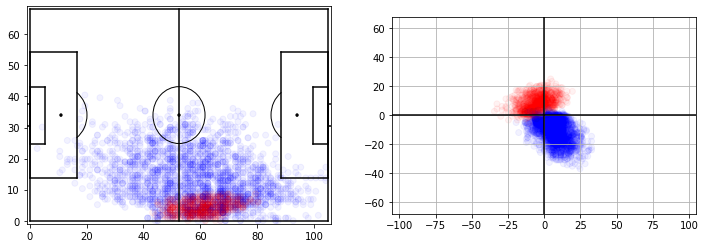

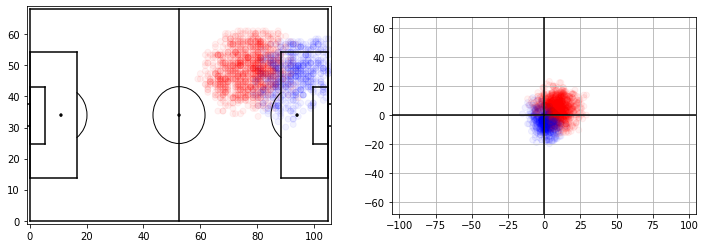

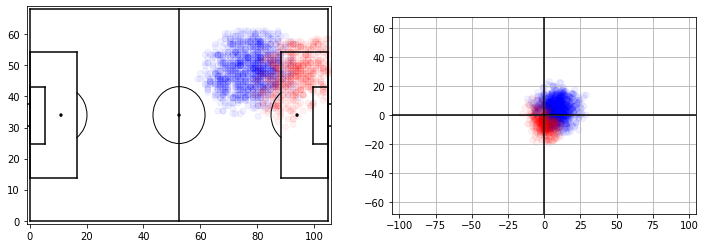

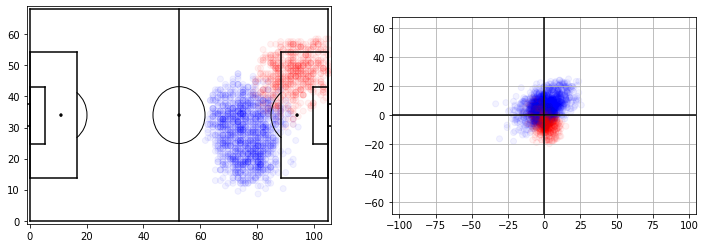

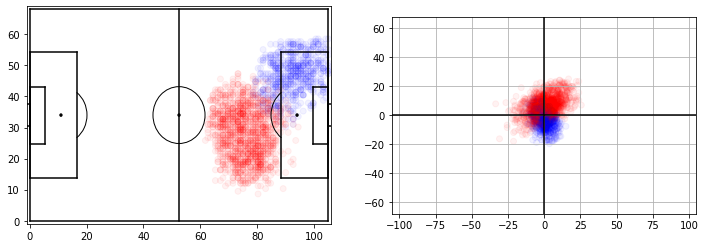

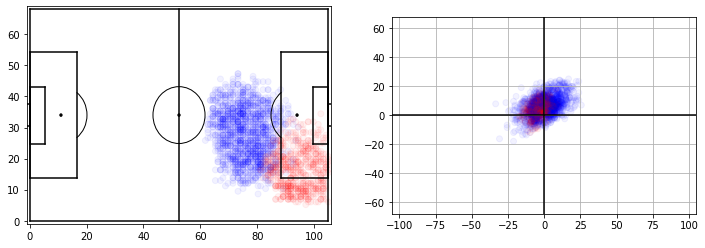

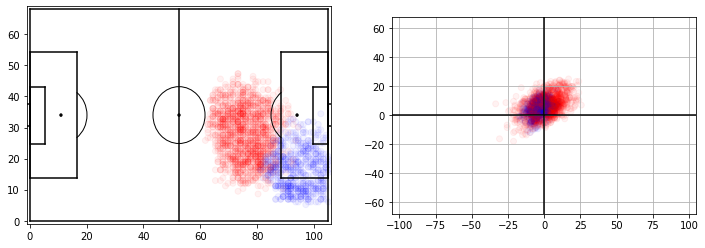

In [186]:
probs = []
for i in range(nbc):
    for j in range(nbc):
        probs.append((trans[i,j],i,j))
probs = sorted(probs,reverse=True)
movs = [(p,i,j) for p,i,j in probs if i != j]
for p,i,j in movs[:20]:
    l_idx = (labels == i) | (labels == j)
    twocolors = ["blue" if l == i else "red" for l in labels[l_idx]]
    plot_deltas(a.x[l_idx],a.y[l_idx],a.dx[l_idx],a.dy[l_idx],color=twocolors)

Text(0.5, 0, 'n_components')

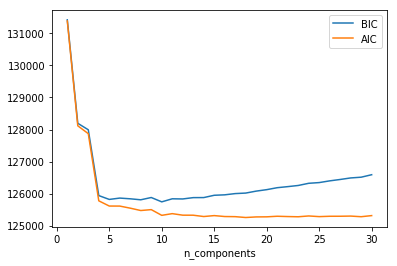

In [136]:
n_components = np.arange(1, 31)
models = [mix.GaussianMixture(n).fit(a[["x","y"]])
          for n in n_components]

plt.plot(n_components, [m.bic(a[["x","y"]]) for m in models], label='BIC')
plt.plot(n_components, [m.aic(a[["x","y"]]) for m in models], label='AIC')
plt.legend(loc='best')
plt.xlabel('n_components')

100%|██████████| 370/370 [00:00<00:00, 459.07it/s]


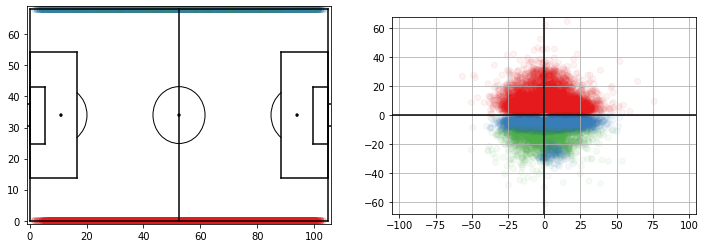

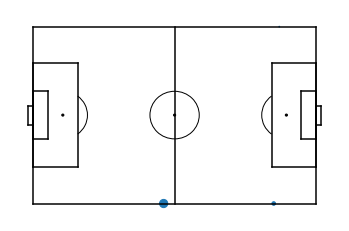

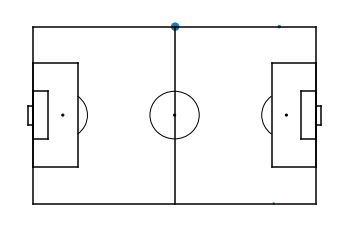

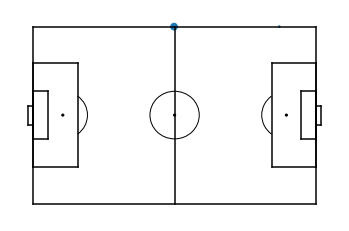

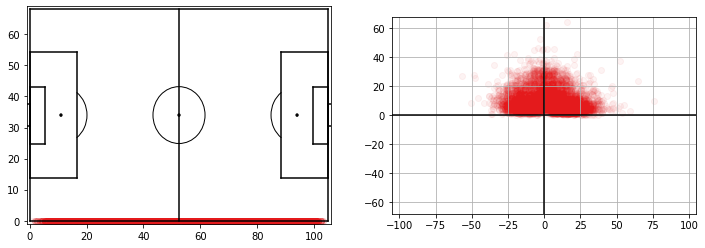

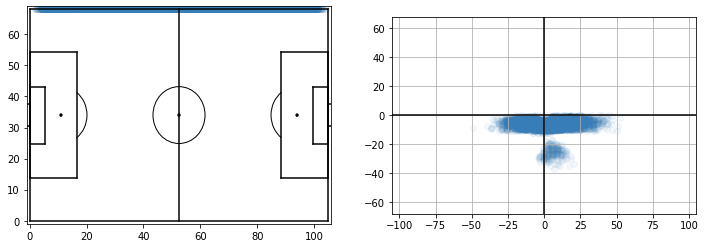

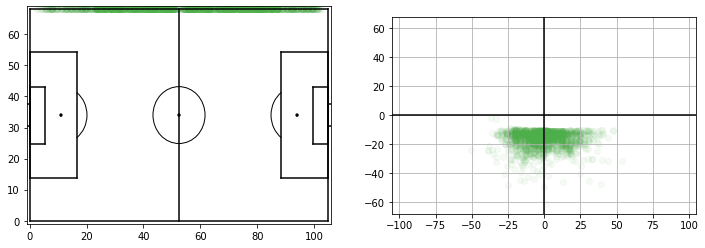

In [201]:
import numpy

nbp = len(set(a.player_id))
vectors = np.zeros((nbp,nbc))

player_ids = []
for i,(player_id,df) in tqdm.tqdm(list(enumerate(a.groupby(["player_id"])))):
    probs = gmm.predict_proba(df[["x","y"
                                  ,"dx","dy"
                                 ]])
    playervector = probs.mean(axis=0)
    player_ids.append(player_id)
    vectors[i,:] = playervector
#vectors


from sklearn.decomposition import NMF
model = NMF(3).fit(vectors)
from sklearn.decomposition import LatentDirichletAllocation as LDA
#model = LDA(6).fit(vectors)
model.components_

components = []
for c in model.components_:
    components.append(c/c.sum())
#model.components_ = np.array(components)
model.components_ = model.components_ / np.linalg.norm(model.components_)

#print(model.components_ )

x = np.array([cc[0] for cc in gmm.means_])
y = np.array([cc[1] for cc in gmm.means_])

# ax = mps.field(show=False)
# for component in model.components_:
#     c_idx = component > 0.1
    
#     ax.scatter(x,y,s=100*component,alpha=0.5)
#     #plt.show()
# plt.show()    

def predict_cluster(points,gmm,nmf):
    gaussprobs = gmm.predict_proba(points)
    clusterscores = nmf.transform(gaussprobs)
    return np.argmax(clusterscores,axis=1)

points = a[["x","y",
            "dx","dy",
           ]].values
clusterlabels = predict_cluster(points,gmm,model)

#ax = mps.field(show=False)
plot_deltas(a.x,a.y,a.dx,a.dy,[list(colors*10)[l] for l in clusterlabels])
#ax.scatter(x,y,color=[colors[l] for l in clusterlabels])
#plt.show()

x = np.array([cc[0] for cc in gmm.means_])
y = np.array([cc[1] for cc in gmm.means_])

for component in model.components_:
    c_idx = component > 0.1
    ax = mps.field(show=False)
    ax.scatter(x,y,s=100*component,alpha=1)
    plt.show()

for l in set(clusterlabels):
    l_idx = clusterlabels == l
    plot_deltas(a.x[l_idx],a.y[l_idx],a.dx[l_idx],a.dy[l_idx],color=(colors * 10)[l])

(array([ 842., 2767., 9516., 9579., 6379., 4105., 2657., 1363., 1491.,
        1301.]),
 array([0.366, 0.623, 0.88 , 1.138, 1.395, 1.652, 1.909, 2.167, 2.424,
        2.681, 2.938]),
 <a list of 10 Patch objects>)

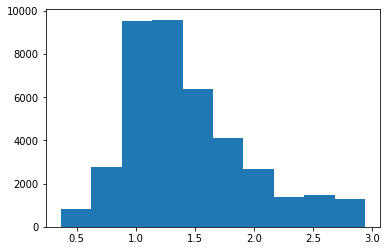

In [194]:
gaussprobs = gmm.predict_proba(points)
clusterscores = model.transform(gaussprobs)
plt.hist(clusterscores.sum(axis=1))

In [107]:
#plt.scatter(range(len(clusterscores[0])),clusterscores.sum(axis=1))
#plt.show()
#plt.hist(clusterscores.sum(axis=1))
#model.components_.sum(axis=1)


array([3137.044,  657.396, 3112.793, 3291.776, 2240.714])